In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, \
BatchNormalization, Cropping2D, Lambda, Activation, Dropout

/Users/fchua/Applications/miniconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/fchua/Applications/miniconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
driving_log = pd.read_csv('data/driving_log.csv', names=['center','left','right','angle','throttle','brake','speed'])

In [3]:
center_angle = driving_log[['center','angle']]

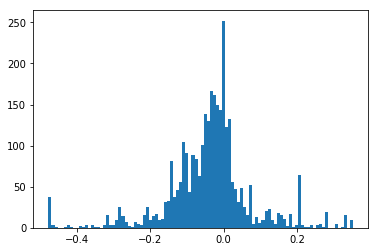

In [9]:
# plot histogram of angle
plt.hist(center_angle.angle, bins=100)
plt.show()

In [10]:
def processFilename(filename):
  filename = filename.split('/')
  filename = 'data/{}/{}'.format(filename[-2], filename[-1])
  return filename
# enddef

In [11]:
def read_images(driving_log, crop=False):
  images = []
  angles = []
  for row in driving_log.itertuples():
    angle = row.angle
    angles.append(angle)
    image = plt.imread( processFilename(driving_log.iloc[2000].center) )
    if crop:
      images.append(image[65:-25,:,:])
    else:
      images.append(image)
    # end if
  # end for
  return np.array(images), np.array(angles)
# end def

In [12]:
images, angles = read_images(center_angle)

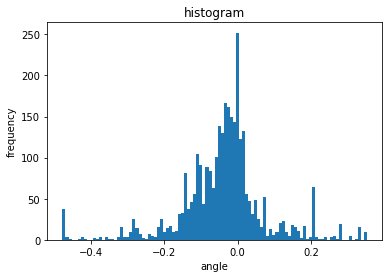

In [16]:
plt.hist(angles, bins=100)
plt.xlabel('angle')
plt.ylabel('frequency')
plt.title('histogram before augmentation')
plt.show()

In [19]:
# augment the data set
augmented_images = []
augmented_angles = []
for image, angle in zip(images, angles):
  augmented_images.append(image)
  augmented_angles.append(angle)
  
  augmented_images.append(cv2.flip(image, 1))
  augmented_angles.append(-angle)
# end for

augmented_images = np.array(augmented_images)
augmented_angles = np.array(augmented_angles)

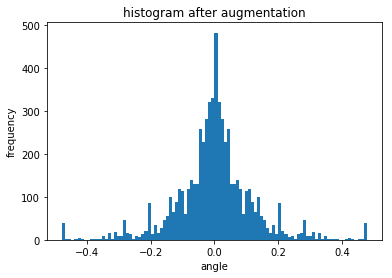

In [20]:
plt.hist(augmented_angles, bins=100)
plt.xlabel('angle')
plt.ylabel('frequency')
plt.title('histogram after augmentation')
plt.show()

# as you can see, it is now normally distributed

In [38]:
mu   = np.mean(augmented_images)
sigma = np.std(augmented_images)

In [41]:
print('mu={}, sigma={}'.format(mu, sigma))

mu=134.86627604166668, sigma=41.75840322975388


In [39]:
augmented_images[0].shape

(160, 320, 3)

In [42]:
def LeNet(input_shape, mu, sigma, dropout=1.0):
  model = Sequential()
  model.add(Lambda(lambda x: (x - mu)/sigma, input_shape=input_shape)) # preprocess, normalization
  model.add(Cropping2D(cropping=((75,25), (0,0))))
  
  # layer 1
  model.add(Conv2D(6, 5, strides=1, activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(dropout, seed=1))
  
  # layer 2
  model.add(Conv2D(16, 5, strides=1, activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(dropout, seed=1))
  
  model.add(Flatten())
  
  model.add(Dense(120, activation='relu'))
  model.add(Dropout(dropout, seed=1))
  
  model.add(Dense(84, activation='relu'))
  model.add(Dropout(dropout, seed=1))
  
  model.add(Dense(1))
  
  return model

model = LeNet(augmented_images[0].shape, mu, sigma)
model.compile(loss='mse', optimizer='adam')

TypeError: LeNet() missing 2 required positional arguments: 'mu' and 'sigma'

In [43]:
np.random.seed(1)

In [12]:
model.fit(x=images, y=angles, batch_size=100, epochs=20, verbose=1, validation_split=0.2, shuffle=True)

Train on 2463 samples, validate on 616 samples
Epoch 1/20
2463/2463 [==============================] - 4s 1ms/step - loss: 0.0510 - val_loss: 0.0236
Epoch 2/20
2463/2463 [==============================] - 2s 764us/step - loss: 0.0113 - val_loss: 0.0238
Epoch 3/20
2463/2463 [==============================] - 2s 761us/step - loss: 0.0115 - val_loss: 0.0221
Epoch 4/20
2463/2463 [==============================] - 2s 760us/step - loss: 0.0114 - val_loss: 0.0239
Epoch 5/20
2463/2463 [==============================] - 2s 761us/step - loss: 0.0113 - val_loss: 0.0238
Epoch 6/20
2463/2463 [==============================] - 2s 761us/step - loss: 0.0113 - val_loss: 0.0234
Epoch 7/20
2463/2463 [==============================] - 2s 762us/step - loss: 0.0113 - val_loss: 0.0250
Epoch 8/20
2463/2463 [==============================] - 2s 764us/step - loss: 0.0113 - val_loss: 0.0237
Epoch 9/20
2463/2463 [==============================] - 2s 762us/step - loss: 0.0113 - val_loss: 0.0239
Epoch 10/20
2463/24

In [13]:
model.save('model.h5')
model.save_weights('model_weights.h5')

In [14]:
json_string = model.to_json()
with open('model_architecture.json', 'w') as fid:
  fid.write(json_string)